In [1]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os
import matplotlib.pylab as plt

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "https://peterbloem.nl/files/mnist/" # "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [2]:
(xtrain, ytrain), (xvalid, yvalid), n_class = load_mnist(flatten=True)

In [ ]:
# support functions 
def sigmoid(values: list):
    """ Sigmoid for vectors"""
    return 1/(1 + np.exp(-values))

def softmax(values: list):
    """ Softmax for vectors"""

    exp_values = np.exp(values - np.max(values)) # substracting max for numerical stability 
    
    return exp_values/np.sum(exp_values)

def forwardpass(input, w1, b1, w2, b2):
    """ Forwards pass for vectors"""
    # feedforward pass
    o1 = np.dot(input, w1) + b1 # first line of linear combination
    h = sigmoid(o1) # sigmoid activation function
    o2 = np.dot(h, w2) + b2 # second linear combination
    y = softmax(o2) # sigmoid activation function

    return o1, h, o2, y

def get_loss(prediction, target):
    """ Calculate loss of current prediction """
    return -np.log(prediction[target])


def deriv_sigmoid(values: list):
    """ Derivative of sigmoid for vectors """
    sigmoid_vals = sigmoid(values)
    return sigmoid_vals*(1 - sigmoid_vals)


def deriv_cross_softmax(pred, target):
    """ Cross_softmax derivative for vectors"""
    grad = np.copy(pred) 
    grad[target] -= 1 # adjust gradient for target
    return grad

def backprop(input, w1, b1, w2, b2, target, o1, h, o2, y):
    """ Backwards pass for vectors"""
    #compute loss
    loss = get_loss(y, target)

    # backwards pass to compute derivatives
    dL_do2 = deriv_cross_softmax(y, target) # deriv. of loss with rep. to the secon linear comb.
    dL_dw2 = np.outer(dL_do2, h).T # deriv. of the loss with regards to second set of weights
    dL_db2 = dL_do2 # deriv. of the loss with respect to the second set of biases
    dL_dh = np.dot(w2, dL_do2) # deriv. of the loss with respects to the output of the sigmoid
    dL_do1 = dL_dh * deriv_sigmoid(o1) # deriv. of the loss with respects to the first linear comb.
    dL_dw1 = np.outer(dL_do1, input).T # deriv. of the loss with respects to the first set of weights
    dL_db1 = dL_do1 # deriv. of the loss with respects to the first set of biases
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def forward_and_backward(input, w1, b1, w2, b2, target):
    """ Union of forward and backwards pass to get derivatives and loss"""
    # feedforward pass
    o1, h, o2, y = forwardpass(input, w1, b1, w2, b2)

    # backwards pass and get derivatives
    dL_dw1, dL_db1, dL_dw2, dL_db2, loss = backprop(input, w1, b1, w2, b2, target, o1, h, o2, y)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha):
    """ Gradient descent """
    # update weights, biases in first layer 
    w1 = w1 - alpha*dL_dw1
    b1 = b1 - alpha*dL_db1
    w2 = w2 - alpha*dL_dw2
    b2 = b2 - alpha*dL_db2

    return w1, b1, w2, b2 

In [ ]:
# Training and plotting functions 
def plot_loss(avg_loss):
    """ Plot avg and epoch Loss """
    plt.figure(figsize=(8,5))
    plt.plot(avg_loss, label = "Avg Loss", linestyle = "-", color = "green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

def train(xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch, batch_size):
    avg_loss = []
    sample_size = xtrain.shape[0]

    for epoch in range(max_epoch):
    # start training in current epoch
        train_loss = 0 
        # create gradient vector for average gradients
        grad_vec = [
                    np.zeros((784, 300)), 
                    np.zeros((300, )),    
                    np.zeros((300, 10)),
                    np.zeros((10,)),
                    0.0
                ]
        # training during epoch
        for iter in range(len(xtrain)):
            
            # compute forwards and backwards pass to get derivatives and loss 
            (dL_dw1, dL_db1, dL_dw2, dL_db2,  loss) = forward_and_backward(xtrain[iter], w1, b1, w2, b2, ytrain[iter])

            # add up gradients to work with averages
            for i, grad in enumerate((dL_dw1, dL_db1, dL_dw2, dL_db2, loss)):
                grad_vec[i] += grad
            
            # update weights when we iterated over a "batch"
            if iter != 0 and iter % batch_size == 0:
                
                # get gradient average 
                grad_vec = [grad/batch_size for grad in grad_vec]
                w1, b1, w2, b2 = gradient_desent(w1, b1, w2, b2, grad_vec[0], grad_vec[1], grad_vec[2], grad_vec[3], alpha)
                
                # update training loss
                train_loss += grad_vec[4]
                
                # set grad_vec to zero
                for i in range(len(grad_vec)):
                    grad_vec[i] *= 0
            
            if  iter % (len(xtrain)* 0.1) == 0:
                print(f"Epoch {epoch + 1} at {round(iter/len(xtrain), 1)*100}%")

        # calculate the avg loss of training
        avg_loss.append(train_loss / round(sample_size/batch_size))

        # randomize dataset
        indices = np.arange(sample_size)
        xtrain = np.array([xtrain[i] for i in indices])
        ytrain = np.array([ytrain[i] for i in indices])


    print(f"w1 weights found = {w1}")
    print(f"b1 biases found = {b1}")
    print(f"w2 weights found = {w2}")
    print(f"b2 biases found = {b2}")

    return avg_loss, w1, b1, w2, b2

##### Derivative shapes

dL_do2 shape = (10,)
dL_dw2 shape = (300, 10)
dL_db2 shape = (10,)
dL_dh shape = (300,)
dL_do1 shape = (300,)
dL_dw1 shape = (784, 300)
dL_db1 shape = (300,)

## Training with Vectorization

Epoch 0, batch 1
Epoch 0, batch 2
Epoch 0, batch 3
Epoch 0, batch 4
Epoch 0, batch 5
Epoch 0, batch 6
Epoch 0, batch 7
Epoch 0, batch 8
Epoch 0, batch 9
Epoch 0, batch 10
Epoch 0, batch 11
Epoch 0, batch 12
Epoch 0, batch 13
Epoch 0, batch 14
Epoch 0, batch 15
Epoch 0, batch 16
Epoch 0, batch 17
Epoch 0, batch 18
Epoch 0, batch 19
Epoch 0, batch 20
Epoch 0, batch 21
Epoch 0, batch 22
Epoch 0, batch 23
Epoch 0, batch 24
Epoch 0, batch 25
Epoch 0, batch 26
Epoch 0, batch 27
Epoch 0, batch 28
Epoch 0, batch 29
Epoch 0, batch 30
Epoch 0, batch 31
Epoch 0, batch 32
Epoch 0, batch 33
Epoch 0, batch 34
Epoch 0, batch 35
Epoch 0, batch 36
Epoch 0, batch 37
Epoch 0, batch 38
Epoch 0, batch 39
Epoch 0, batch 40
Epoch 0, batch 41
Epoch 0, batch 42
Epoch 0, batch 43
Epoch 0, batch 44
Epoch 0, batch 45
Epoch 0, batch 46
Epoch 0, batch 47
Epoch 0, batch 48
Epoch 0, batch 49
Epoch 0, batch 50
Epoch 0, batch 51
Epoch 0, batch 52
Epoch 0, batch 53
Epoch 0, batch 54
Epoch 0, batch 55
Epoch 0, batch 56
E

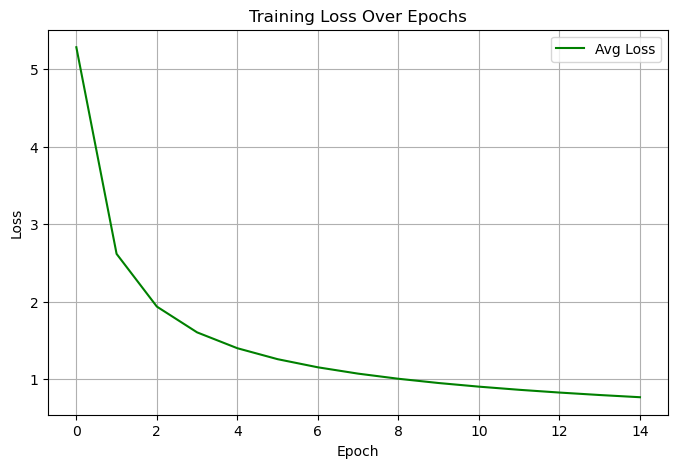

In [ ]:
# setting for network
hidden_layer = 300
input_size = 784    
output_size = 10

# initialization of weights
w1 = np.random.normal(loc = 0.0, scale = 1.0, size=(input_size, hidden_layer))
b1 = np.zeros(hidden_layer)
w2 = np.random.normal(loc = 0.0, scale = 1.0, size = (hidden_layer, output_size))
b2 = np.zeros(output_size)

#normalization of data 
norm_xtrain = (xtrain/255.0)
# train model
alpha = 0.01
max_epoch = 15
batch_size = 64
avg_loss = train(norm_xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch, batch_size)

# plot loss
plot_loss(avg_loss)


## Tensor implement. for Mini-batch training 

In [ ]:
def sigmoid(values: list):
    """ Sigmoid for vectors"""
    return 1/(1 + np.exp(-values))

def softmax(values: list):
    """ Softmax for vectors"""
    exp_values = np.exp(values - np.max(values, axis=1, keepdims=True)) # substracting max for numerical stability 
    return exp_values/np.sum(exp_values, axis = -1, keepdims = True)

def get_loss(predictions, targets):
    """ Calculate loss of current prediction """
    batch_size = predictions.shape[0]
    # epsilon = 1e-12 # buffer to prevent overflow
    loss = np.sum(-np.log(predictions[np.arange(batch_size), targets])) 
    return  loss / batch_size


def deriv_sigmoid(values: list):
    """ Derivative of sigmoid for vectors """
    sigmoid_vals = sigmoid(values)
    return sigmoid_vals*(1 - sigmoid_vals)


def deriv_cross_softmax(pred, target):
    """ Cross_softmax derivative for Tensors"""
    grad = np.copy(pred) 
    batch_size = pred.shape[0]
    grad[np.arange(batch_size), target] -= 1 # adjust gradient for target
    return grad/batch_size

def forwardpass(input, w1, b1, w2, b2):
    """ Feedforward pass with Tensor implementation using batches"""
    # feedforward pass

        # (batch_size, input)@(input, n_hidden) -> (batch_size, n_hidden)
    O1 = np.matmul(input, w1) + b1 # first line of linear combination
        # sigmoid( (batch_size, n_hidden) ) -> (batch_size, n_hidden)
    H = sigmoid(O1) # sigmoid activation function
        # (batch_size, n_hidden)@(n_hidden, output) -> (batch_size, output)
    O2 = np.matmul(H, w2) + b2 # second linear combination
        # softmax( (batch_size, output) ) -> (batch_size, output)
    Y = softmax(O2) # sigmoid activation function

    return O1, H, O2, Y

def backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y):
    """ Backpropagation in Tensor implementation for batches"""
    #compute loss
    loss = get_loss(Y, target)

    # backwards pass to compute derivatives
        # (batch_size, output)
    dL_do2 = deriv_cross_softmax(Y, target) # deriv. of loss with rep. to the ouput of the softmax
        #  (n_hidden, batch_six)(batch_size, output)-> (n_hidden, output)
    dL_dw2 = np.matmul(H.T, dL_do2)# deriv. of the loss with regards to second set of weights
        # (output, )
    dL_db2 = np.sum(dL_do2, axis = 0) # deriv. of the loss with respect to the second set of biases
        # (batch_size, output)@(output, n_hidden) -> (batch_size, n_hidden)
    dL_dh = np.matmul(dL_do2, w2.T) # deriv. of the loss with respects to the output of the sigmoid
        # (batch_size, n_hidden)@(batch_size, n_hidden)-> (batch_size, n_hidden)
    dL_do1 = dL_dh * deriv_sigmoid(O1) # deriv. of the loss with respects to the first linear comb.
        # (input, batch_size)@(batch_size, n_hidden) -> (input, n_hidden)
    dL_dw1 = np.matmul(input.T, dL_do1) # deriv. of the loss with respects to the first set of weights
        # (n_hidden, )
    dL_db1 = np.sum(dL_do1, axis = 0) # deriv. of the loss with respects to the first set of biases
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def forward_and_backward(input, w1, b1, w2, b2, target):
    # feedforward pass
    O1, H, O2, Y = forwardpass(input, w1, b1, w2, b2)

    # backwards pass and get derivatives
    dL_dw1, dL_db1, dL_dw2, dL_db2, loss = backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha):
    # update weights and biases
    w1 -= alpha * dL_dw1
    b1 -= alpha * dL_db1
    w2 -= alpha * dL_dw2
    b2 -= alpha * dL_db2

    return w1, b1, w2, b2

In [53]:
def sigmoid(values: list):
    """ Sigmoid for vectors"""
    return 1/(1 + np.exp(-values))

def softmax(values: list):
    """ Softmax for vectors"""
    exp_values = np.exp(values - np.max(values, axis=1, keepdims=True)) # substracting max for numerical stability 
    return exp_values/np.sum(exp_values, axis = -1, keepdims = True)

def get_loss(predictions, targets):
    """ Calculate loss of current prediction """
    batch_size = predictions.shape[0]
    # epsilon = 1e-12 # buffer to prevent overflow
    loss = np.sum(-np.log(predictions[np.arange(batch_size), targets])) 
    return  loss / batch_size


def deriv_sigmoid(values: list):
    """ Derivative of sigmoid for vectors """
    sigmoid_vals = sigmoid(values)
    return sigmoid_vals*(1 - sigmoid_vals)


def deriv_cross_softmax(pred, target):
    """ Cross_softmax derivative for Tensors"""
    grad = np.copy(pred) 
    batch_size = pred.shape[0]
    grad[np.arange(batch_size), target] -= 1 # adjust gradient for target
    return grad/batch_size

def forwardpass(input, w1, b1, w2, b2):
    """ Feedforward pass with Tensor implementation using batches"""
    # feedforward pass

        # (batch_size, n_hidden)
    O1 = np.matmul(input, w1) + b1 # first line of linear combination

        # (batch_size, n_hidden)
    H = sigmoid(O1) # sigmoid activation function

        # (batch_size, output)
    O2 = np.matmul(H, w2) + b2 # second linear combination

        # (batch_size, output)
    Y = softmax(O2) # sigmoid activation function

    return O1, H, O2, Y

def backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y):
    """ Backpropagation with Tensor implementation using batches"""
    #compute loss
    loss = get_loss(Y, target)

    # backwards pass to compute derivatives

        # (batch_size, output)
    dL_do2 = deriv_cross_softmax(Y, target) # deriv. of loss with rep. to the softmax output
    
        # (n_hidden, output)
    dL_dw2 = np.matmul(H.T, dL_do2)# deriv. of the loss with respect to w2
    
        # (output, )
    dL_db2 = np.sum(dL_do2, axis = 0) # deriv. of the loss with respect to b2
    
        # (batch_size, n_hidden)
    dL_dh = np.matmul(dL_do2, w2.T) # deriv. of the loss with respect to the sigmoid output
    
        #(batch_size, n_hidden)
    dL_do1 = dL_dh * deriv_sigmoid(O1) # deriv. of the loss with respect to the first linear comb.
    
        # (input, n_hidden)
    dL_dw1 = np.matmul(input.T, dL_do1) # deriv. of the loss with respects to w1
    
        # (n_hidden, )
    dL_db1 = np.sum(dL_do1, axis = 0) # deriv. of the loss with respects to b1
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss


def forward_and_backward(input, w1, b1, w2, b2, target):
    # feedforward pass
    O1, H, O2, Y = forwardpass(input, w1, b1, w2, b2)

    # backwards pass and get derivatives
    dL_dw1, dL_db1, dL_dw2, dL_db2, loss = backprop(input, w1, b1, w2, b2, target, O1, H, O2, Y)
    
    return dL_dw1, dL_db1, dL_dw2, dL_db2, loss

def gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha):
    # update weights and biases
    w1 -= alpha * dL_dw1
    b1 -= alpha * dL_db1
    w2 -= alpha * dL_dw2
    b2 -= alpha * dL_db2

    return w1, b1, w2, b2

In [ ]:
# Training and plotting functions 
def plot_loss(avg_loss):
    """ Plot avg and epoch Loss """
    plt.figure(figsize=(8,5))
    plt.plot(avg_loss, label = "Avg batch Loss", linestyle = "-", color = "green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

def batch_train(xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch, batch_size):
    avg_loss = []

    for epoch in range(max_epoch):
    # start training in current epoch
        train_loss = 0
        
        # training during epoch
        for iter in range(0, len(xtrain), batch_size):
            
            # get batch for current iteration 
            xbatch = xtrain[iter : batch_size + iter]
            ybatch = ytrain[iter : batch_size + iter]
            
            # compute forwards and backwards pass to get derivatives and loss 
            dL_dw1, dL_db1, dL_dw2, dL_db2,  loss = forward_and_backward(xbatch, w1, b1, w2, b2, ybatch)

            # aggregate loss 
            train_loss += loss

            # update weights through gradient descent 
            w1, b1, w2, b2 = gradient_desent(w1, b1, w2, b2, dL_dw1, dL_db1, dL_dw2, dL_db2, alpha)    
           
        # calculate the avg loss of training
        avg_loss.append(train_loss / (len(xtrain) / batch_size))

        # randomize dataset
        indices = np.arange(len(xtrain))
        xtrain = np.array([xtrain[i] for i in indices])
        ytrain = np.array([ytrain[i] for i in indices])

        print(f"Epoch {epoch + 1} finished")

    return avg_loss, w1, b1, w2, b2

C:\Users\agdse\AppData\Local\Temp\ipykernel_31612\2311590385.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-values))


Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished
Epoch 21 finished
Epoch 22 finished
Epoch 23 finished
Epoch 24 finished
Epoch 25 finished
Epoch 26 finished
Epoch 27 finished
Epoch 28 finished
Epoch 29 finished
Epoch 30 finished
Epoch 31 finished
Epoch 32 finished
Epoch 33 finished
Epoch 34 finished
Epoch 35 finished
Epoch 36 finished
Epoch 37 finished
Epoch 38 finished
Epoch 39 finished
Epoch 40 finished
Epoch 41 finished
Epoch 42 finished
Epoch 43 finished
Epoch 44 finished
Epoch 45 finished
Epoch 46 finished
Epoch 47 finished
Epoch 48 finished
Epoch 49 finished
Epoch 50 finished
w1 weights found = [[-5.34137873e-01  6.28648375e-01 -1.73501116e-01 ... -1.17666007e+00
   8.34877704e-01  1

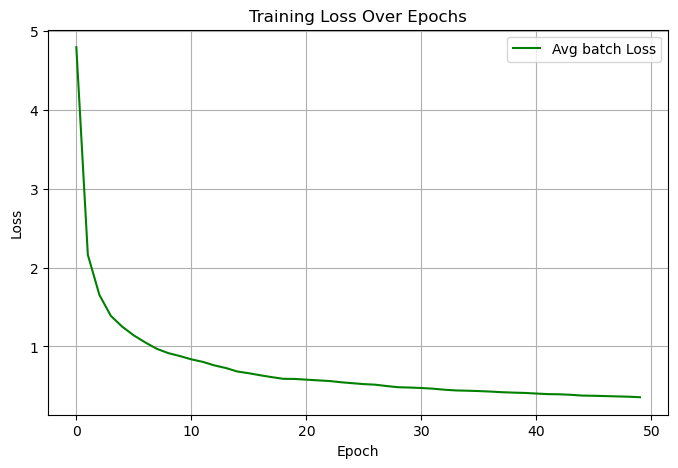

In [51]:
# setting for network
hidden_layer = 300
input_size = xtrain.shape[1]
output_size = 10

# initialization of weights
w1 = np.random.randn(input_size, hidden_layer)
b1 = np.zeros(hidden_layer)
w2 = np.random.randn(hidden_layer, output_size)
b2 = np.zeros(output_size)

# normalizing data
xtrain_norm = xtrain/255.0

# train model
alpha = 0.02
max_epoch = 50
batch_size = 64
avg_loss, w1, b1, w2, b2 = batch_train(xtrain, ytrain, w1, b1, w2, b2, alpha, max_epoch, batch_size)

# plot loss
plot_loss(avg_loss)